# Medical Imaging 2020/2021
## Lab 5
### Group 4
Ana Rita Baião 89788, João Alves 89812, Francisca Xara-Brasil 89825 e Tiago Franco 89840

#### Import Relevant Libraries

In [1]:
import numpy as np
import math
import cmath
from scipy.io import loadmat
from PIL import Image
from matplotlib import pyplot as plt
#from roipoly import RoiPoly
from scipy.ndimage import gaussian_filter
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
from skimage.util import random_noise
from PIL import Image

#### Parameters

In [2]:
# Parameters

T1 = 0.6 #longitudinal time constant
T2 = 0.06 #transverse time constant

M0 = [0, 0, 1]

TE = 0.015 #time of excitation
TR = 0.15 #time of relaxation

dt = 0.0005 #time step

theta_E = math.pi/2 #excitation angle
theta_I = math.pi #inversion angle

#### Exercise 1
Simulate the evolution of the magnetization during one TR, and plot each
magnetization component as a function of time.

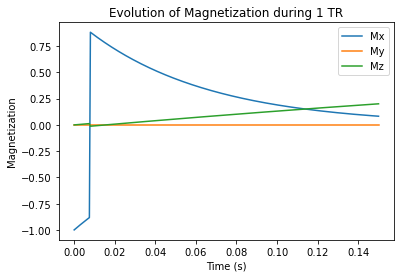

In [3]:
# On resonance spins - delta_w = 0

M = np.zeros((3,int(TR/dt)+1))

# Initial magnetization after excitation
M[:,0] = np.matmul([[math.cos(theta_E), 0, -math.sin(theta_E)], [0, 1, 0], [math.sin(theta_E), 0, math.cos(theta_E)]], M0)


for i in range(0,int(TR/dt)):
    if i*dt == TE/2:
        M[:,i+1] = np.matmul([[math.cos(theta_I), 0, -math.sin(theta_I)], [0, 1, 0], [math.sin(theta_I), 0, math.cos(theta_I)]], M[:,i])
        
    else:
        M[:,i+1] = np.matmul([[math.exp(-dt/T2), 0, 0], [0, math.exp(-dt/T2), 0], [0, 0, math.exp(-dt/T1)]], M[:,i]) + [0, 0, np.linalg.norm(M0)*(1-math.exp(-dt/T1))]



t = np.linspace(0, TR, num=int(TR/dt)+1)
plt.plot(t, M[0,:], label = 'Mx')
plt.plot(t, M[1,:], label = 'My')
plt.plot(t, M[2,:], label = 'Mz')
plt.title('Evolution of Magnetization during 1 TR')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()


#### Exercise 2
Compute the complex transverse magnetization, and plot its amplitude and phase as
a function of time.

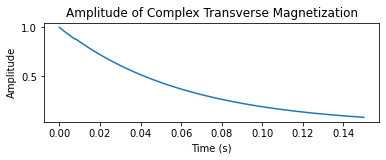

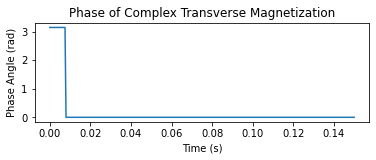

In [5]:
Mxy = M[0,:] + 1j*M[1,:] #complex transverse magnetization
amp = abs(Mxy) #magnitude
phase = np.zeros((1,int(TR/dt)+1))

for i in range (0,int(TR/dt)):
    phase[0,i] = cmath.phase(Mxy[i]) #phase
    
t = np.linspace(0, TR, num=int(TR/dt)+1)

plt.subplot(2,1,1)
plt.plot(t, amp)
plt.title('Amplitude of Complex Transverse Magnetization')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.subplot(2,1,2)
plt.plot(t, phase[0,:])
plt.title('Phase of Complex Transverse Magnetization')
plt.xlabel('Time (s)')
plt.ylabel('Phase Angle (rad)')
plt.show()

#### Exercise 3
Now consider an ensemble of off-resonance spins with Δω between -50 and +50 Hz, in steps of
1 Hz. Repeat 1. and 2.; for the plots, consider the average magnetization of all spins.

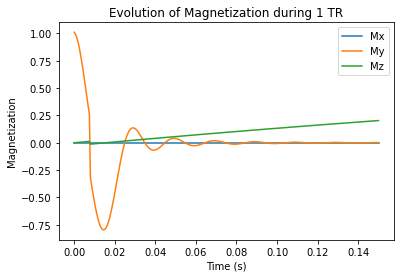

In [51]:
M = np.zeros((3,int(TR/dt)+1))
M_sum = np.zeros((3,int(TR/dt)+1))

# Initial magnetization after excitation
M[:,0] = np.matmul([[1, 0, 0], [0, math.cos(theta_E), math.sin(theta_E)], [0, -math.sin(theta_E), math.cos(theta_E)]], M0)

for j in range(-50,51):
    delta_w = 2*math.pi*j; #rad/s (delta omega)
    
    for i in range(0,int(TR/dt)):
        if i*dt == TE/2:
            
            # Rotation 180º about x (inversion) and then rotation about z (precession)
            M[:,i+1] = np.matmul(np.matmul([[math.cos(delta_w*dt), math.sin(delta_w*dt), 0], [-math.sin(delta_w*dt), math.cos(delta_w*dt), 0], [0,0,1]], [[1, 0, 0], [0, math.cos(theta_I), math.sin(theta_I)], [0, -math.sin(theta_I), math.cos(theta_I)]]), M[:,i])
        
        else:
            # Relaxation and then rotation about z (precession)
            M[:,i+1] = np.matmul(np.matmul([[math.cos(delta_w*dt), math.sin(delta_w*dt), 0], [-math.sin(delta_w*dt), math.cos(delta_w*dt), 0], [0,0,1]], [[math.exp(-dt/T2), 0, 0], [0, math.exp(-dt/T2), 0], [0, 0, math.exp(-dt/T1)]]), M[:,i]) + [0, 0, np.linalg.norm(M0)*(1-math.exp(-dt/T1))]
    
    M_sum = M_sum + M
    
M_sum = M_sum/100 # normalized
t = np.linspace(0, TR, num=int(TR/dt)+1)
Mx = M_sum[0,:]
My = M_sum[1,:]
Mz = M_sum[2,:]

plt.plot(t, M_sum[0,:], label = 'Mx')
plt.plot(t, M_sum[1,:], label = 'My')
plt.plot(t, M_sum[2,:], label = 'Mz')
plt.title('Evolution of Magnetization during 1 TR')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()


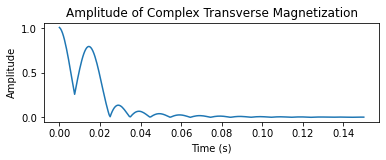

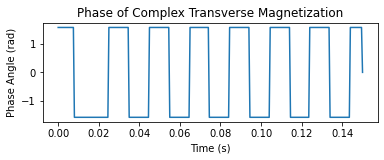

In [52]:
# Amplitude and phaseas a function of time

Mxy_sum = M_sum[0,:] + 1j*M_sum[1,:] #complex transverse magnetization
amp = abs(Mxy_sum) #magnitude
phase = np.zeros((1,int(TR/dt)+1))

for i in range (0,int(TR/dt)):
    phase[0,i] = cmath.phase(Mxy_sum[i]) #phase
    
t = np.linspace(0, TR, num=int(TR/dt)+1)

plt.subplot(2,1,1)
plt.plot(t, amp)
plt.title('Amplitude of Complex Transverse Magnetization')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.subplot(2,1,2)
plt.plot(t, phase[0,:])
plt.title('Phase of Complex Transverse Magnetization')
plt.xlabel('Time (s)')
plt.ylabel('Phase Angle (rad)')
plt.show()

#### Exercise 4
Repeat 3. for a multiple spin-echo experiment with 5 echoes, and determine the T2
of the sample using the data measured in this experiment.

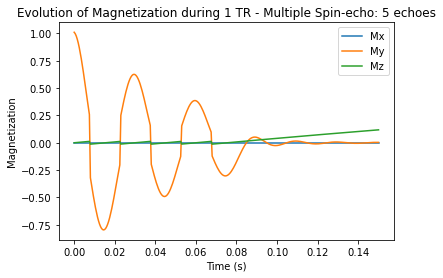

In [53]:
M = np.zeros((3,int(TR/dt)+1))
M_sum = np.zeros((3,int(TR/dt)+1))

# Initial magnetization after excitation
M[:,0] = np.matmul([[1, 0, 0], [0, math.cos(theta_E), math.sin(theta_E)], [0, -math.sin(theta_E), math.cos(theta_E)]], M0)

for j in range(-50,51):
    delta_w = 2*math.pi*j; #rad/s (delta omega)
    
    for i in range(0,int(TR/dt)):
        if i*dt == TE/2 or i*dt == (TE*3/2) or i*dt == (TE*5/2) or i*dt == (TE*7/2) or i*dt == (TE*9/2):
            
            # Rotation 180º about x (inversion) and then rotation about z (precession)
            M[:,i+1] = np.matmul(np.matmul([[math.cos(delta_w*dt), math.sin(delta_w*dt), 0], [-math.sin(delta_w*dt), math.cos(delta_w*dt), 0], [0,0,1]], [[1, 0, 0], [0, math.cos(theta_I), math.sin(theta_I)], [0, -math.sin(theta_I), math.cos(theta_I)]]), M[:,i])
        
        else:
            # Relaxation and then rotation about z (precession)
            M[:,i+1] = np.matmul(np.matmul([[math.cos(delta_w*dt), math.sin(delta_w*dt), 0], [-math.sin(delta_w*dt), math.cos(delta_w*dt), 0], [0,0,1]], [[math.exp(-dt/T2), 0, 0], [0, math.exp(-dt/T2), 0], [0, 0, math.exp(-dt/T1)]]), M[:,i]) + [0, 0, np.linalg.norm(M0)*(1-math.exp(-dt/T1))]
    
    M_sum = M_sum + M
    
M_sum = M_sum/100; # normalized
t = np.linspace(0, TR, num=int(TR/dt)+1)
Mx = M_sum[0,:]
My = M_sum[1,:]
Mz = M_sum[2,:]

plt.plot(t, M_sum[0,:], label = 'Mx')
plt.plot(t, M_sum[1,:], label = 'My')
plt.plot(t, M_sum[2,:], label = 'Mz')
plt.title('Evolution of Magnetization during 1 TR - Multiple Spin-echo: 5 echoes')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()
    

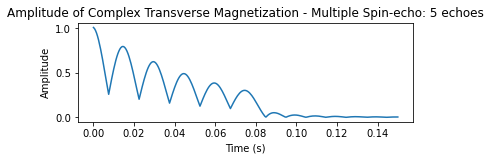

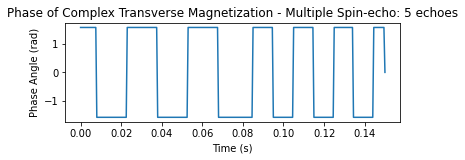

In [54]:
# Amplitude and phaseas a function of time

Mxy_sum = M_sum[0,:] + 1j*M_sum[1,:] #complex transverse magnetization
amp = abs(Mxy_sum) #magnitude
phase = np.zeros((1,int(TR/dt)+1))

for i in range (0,int(TR/dt)):
    phase[0,i] = cmath.phase(Mxy_sum[i]) #phase
    
t = np.linspace(0, TR, num=int(TR/dt)+1)

plt.subplot(2,1,1)
plt.plot(t, amp)
plt.title('Amplitude of Complex Transverse Magnetization - Multiple Spin-echo: 5 echoes')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.subplot(2,1,2)
plt.plot(t, phase[0,:])
plt.title('Phase of Complex Transverse Magnetization - Multiple Spin-echo: 5 echoes')
plt.xlabel('Time (s)')
plt.ylabel('Phase Angle (rad)')
plt.show()

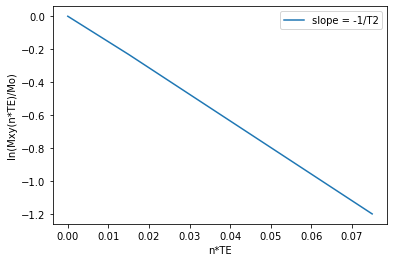

0.06243621338744286


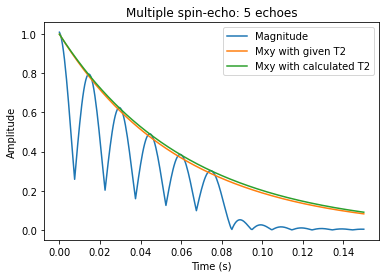

0.0634387897935973


In [55]:
# T2 of the sample

# from the slides Mxy(nTE) = Mo * e^(- n*TE /T2)
# T2 = -(n*TE)/ln(Mxy (nTE)/Mo)

n = np.linspace(0,5,6)

Mo = 1
amp_xy = np.zeros((1,6))
amp_xy[0][0] = 1

for i in range(1,6):
    amp_xy[0][i] = amp[int(n[i]*(TE/dt))]   
    
x = (np.multiply(n, TE))
y = np.log(amp_xy)

plt.plot(x, y[0], label='slope = -1/T2')
plt.xlabel('n*TE')
plt.ylabel('ln(Mxy(n*TE)/Mo)')
plt.legend()
plt.show()
coefficients = np.polyfit(x, y[0], 1)


# Now get the slope, which is the first coefficient in the array:
T2_1= -1/coefficients[0]
print(T2_1)


t = np.linspace(0, TR, num=int(TR/dt)+1)
mxy_t2g = np.linspace(0, TR, num=int(TR/dt)+1)
mxy_t2c = np.linspace(0, TR, num=int(TR/dt)+1)

for i in range (0,len(t)):
    mxy_t2g[i] = math.exp(-t[i]/T2)*Mo
    
for i in range (0,len(t)):
    mxy_t2c[i] = math.exp(-t[i]/T2_1)*Mo
    

plt.plot(t, amp, label='Magnitude') 
plt.plot(t, mxy_t2g,label='Mxy with given T2') 
plt.plot(t, mxy_t2c,label='Mxy with calculated T2') 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Multiple spin-echo: 5 echoes')
plt.legend()
plt.show()

# o we can also do the average of the values obtained by just writing the equation as a function of T2
# T2 = -(n*TE)/ln(Mxy (nTE)/Mo) with Mo=1

num = np.linspace(0,5,6)
for i in range(0,6):
    num[i] = -n[i]*TE
    
T2_2 = np.mean(np.divide(num[1:-1],y[0][1:-1]))

print(T2_2)
